# Movie Genre Classification

This notebook is meant to show a simple process for multilabel classification of movie genres. It is not intended to show how a full optimized model would look.

# Dependencies

In [38]:
%matplotlib inline
import os

#Data Science
import pandas as pd
import numpy as np

# This allows using pandas.progress_apply()
from tqdm.auto import tqdm
tqdm.pandas()

# Language packages
import re
import nltk

# SKlearn 
from sklearn.model_selection import train_test_split
# Bag of Words, TFIDF
from sklearn.feature_extraction.text import CountVectorizer,  TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Functions

## Text Preprocessing

Reads in the genre column value, and determines if the genre string appears in the genre description or not. Results in Multi label task

In [2]:
def onehot_genre(df_, genre_list):
    genre_str = df_['genre']
    
    for column in genre_list:
        if column in genre_str:
            df_[column] = 1
        else:
            df_[column] = 0
            
    return df_

Helper function to conver the one-hot vector into a concatenated string where movie genres are comma separated

In [3]:
def decode_genre_multilabel(encoded_row, genre_list_):
    encoded_bool = encoded_row.astype(bool)
    decoded = np.array(genre_list_)[encoded_bool]
    
    # This occurs if no label was predicted ie all 0s.
    if decoded.shape[0] == 0:
        decoded = ['NO VALUE']
        
    decoded = ", ".join(decoded)
    return decoded

Wrapper to run the decoder across all rows in dataset

In [4]:
def decode_genres(genres_encoded, one_hot_decoder):
    decoded_genres = []
    
    for row in genres_encoded:
        decoded_genre = decode_genre_multilabel(row, one_hot_decoder)
        decoded_genres.append(decoded_genre)
        
    return decoded_genres

Clean the text

In [44]:
def preprocess_text(text, 
                    stopwords=True, 
                    stopwords_language="english",
                    stem=True, lemmatize=True):
    

    # removes any non space or non word (punctuation), 
    # then lowers and strips
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    #tokenize
    text_word_list = text.split()

    # remove stopwords
    if stopwords:
        lst_stopwords = nltk.corpus.stopwords.words(stopwords_language)
        text_word_list = [word for word in text_word_list 
                          if word not in lst_stopwords]

    # Stemming
    if stem:
        ps = nltk.stem.porter.PorterStemmer()
        text_word_list = [ps.stem(word) for word in text_word_list]

    # Lemmatize
    if lemmatize:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        text_word_list = [lem.lemmatize(word) for word in text_word_list]

    text = " ".join(text_word_list)

    return text

## Model Evaluation

Appends the predictions and actuals to original dataframe along with a column `complete_correct` boolean for whether or not all true labels were uncovered

In [6]:
def get_results_table(df_, genre_preds, genre_actuals):
    
    return (
        df_
        .assign(
            genre_pred=genre_preds,
            genre_actual=genre_actuals,
            complete_correct=lambda x: x['genre_actual'] == x['genre_pred'])
        )

## Feature Selection

In [125]:
# using chi2 
def get_significant_features(y_, word_vector_names, alpha=0.05):

    df_features = pd.DataFrame()
    for cat in np.unique(y_):
        chi_sq, p = chi2(tfidf_train_clean, y==cat)
        df_features = (
            df_features
            .append(
                pd.DataFrame({'feature': words, 'score': p, 'y': cat}))
            .sort_values(['y', 'score'])
            .query(f'score < {alpha}'))
    return df_features

In [183]:
def get_top_features_by_genre(genre_list_, vectorizer_):
    important_features_by_genre = {}
    words = vectorizer_.get_feature_names()
    for genre in genre_list_:
        y = y_train.T[genre_list_.index(genre)]
        important_features_by_genre[genre] = get_significant_features(y, words)
        
    return important_features_by_genre

In [191]:
def get_feature_set(top_features_by_genre, set_type='union', print_summary=True):
    
    if set_type == 'union':
        feature_set = set()
        for key in top_features_by_genre:
            [feature_set.add(feature) for feature in 
             important_features_by_genre[key]['feature']]
            if print_summary:
                print(f"\nTop imporant words in {key} plots:")
                print(important_features_by_genre[key]
                      .head(5)
                      .values)
    else:
        print(f"{set_type} not defined as a set type")
        return
    
    return feature_set
    
    

# Load Data

In [7]:
df_base = pd.read_csv('wiki-movie.csv')
# Make columns easier for data manipulation
df_base.columns = [
    col.lower().replace(" ", "_").replace("/", "_")
    for col in df_base.columns]

In [8]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   release_year      34886 non-null  int64 
 1   title             34886 non-null  object
 2   origin_ethnicity  34886 non-null  object
 3   director          34886 non-null  object
 4   cast              33464 non-null  object
 5   genre             34886 non-null  object
 6   wiki_page         34886 non-null  object
 7   plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [9]:
# Make a copy of the base table in case need to recover base state
df = df_base.copy()

Remove rows where genre was **unknown**

In [10]:
df = (
    df.query("genre != 'unknown'")
    .filter(['director', 'genre', 'plot'])
)
df.head(5)

,director,genre,plot
6,Edwin S. Porter,western,The film opens with two bandits breaking into ...
7,Wallace McCutcheon,comedy,The film is about a family who move to the sub...
10,Wallace McCutcheon and Edwin S. Porter,short,The Rarebit Fiend gorges on Welsh rarebit at a...
11,Francis J. Marion and Wallace McCutcheon,short action/crime western,The film features a train traveling through th...
12,Edwin S. Porter,short film,Irish villager Kathleen is a tenant of Captain...


Making a list of genres to focus on, then encoding based on whether that text is found in the genre colum of the training dataset.  
**NOTE** This is set up as a multilabel classification task since some genres are combination of multiple genres

In [11]:
genre_list = ['comedy', 'western', 'drama', 'action', 'thriller', 'adventure', 'fantasy']
assign_kwargs = {genre: np.nan for genre in genre_list}
df = (
    df
    # Make empty columns with NaN
    .assign(**assign_kwargs)
    # Fill in columns with 1 if genre comes up or 0 if not in the genre column
    .apply(onehot_genre, axis=1, args=(genre_list,))
)

In [12]:
df.head(2)

,director,genre,plot,comedy,western,drama,action,thriller,adventure,fantasy
6,Edwin S. Porter,western,The film opens with two bandits breaking into ...,0,1,0,0,0,0,0
7,Wallace McCutcheon,comedy,The film is about a family who move to the sub...,1,0,0,0,0,0,0


Just looking at counts of each genre in the dataset. Mind that since these are not mutually exclusive genres, some combinations may be more imbalanced by nature

In [33]:
df[genre_list].sum()

fantasy       547
adventure     867
western       974
thriller     1780
action       2450
comedy       7266
drama        9475
dtype: int64

<AxesSubplot:>

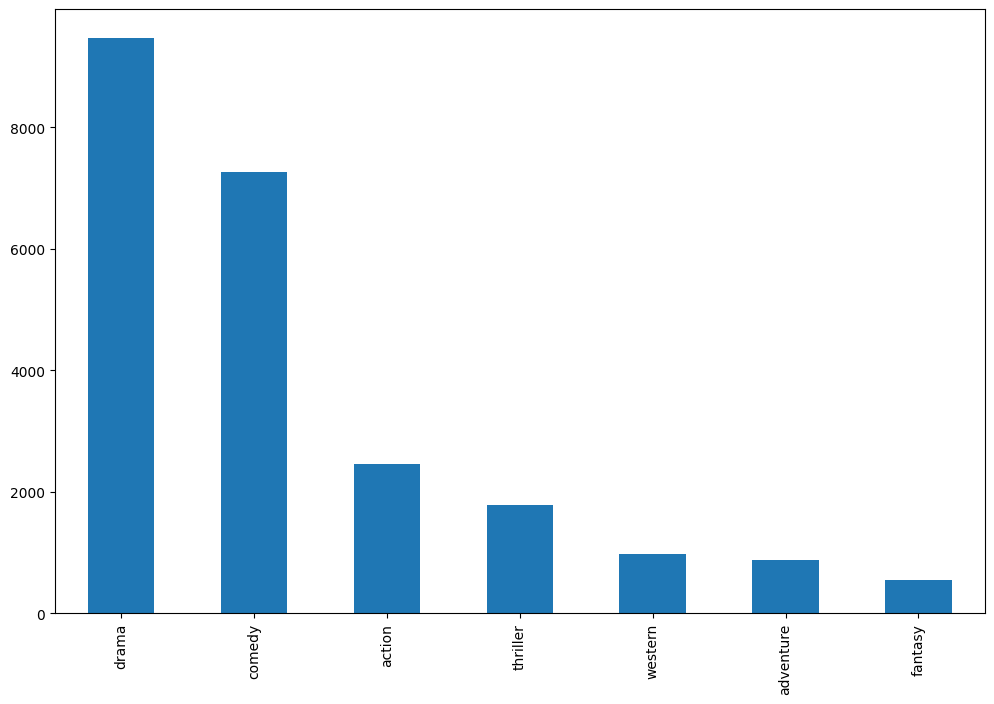

In [39]:
df[genre_list].sum().sort_values(ascending=False).plot.bar()

<AxesSubplot:xlabel='0'>

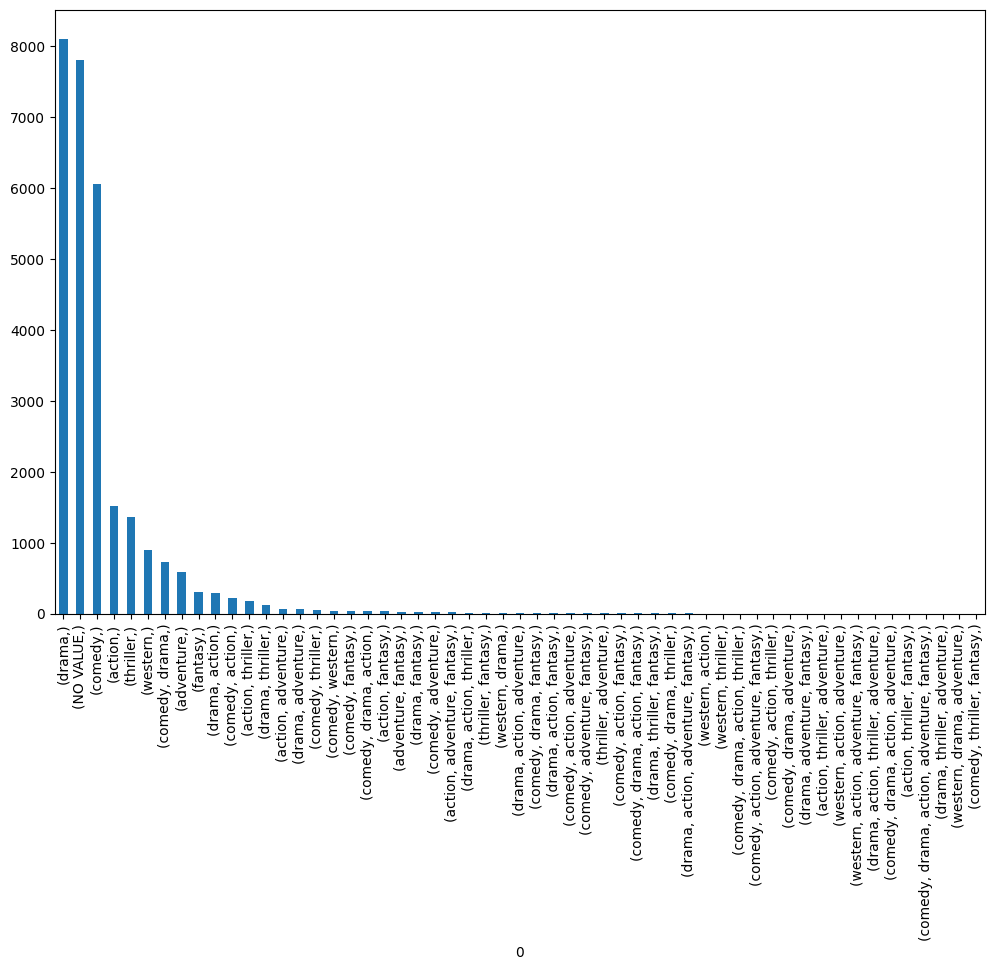

In [40]:
(
    pd.DataFrame(
        decode_genres(df[genre_list].values, genre_list))
    .value_counts()
    
).plot.bar()

# Clean Data

In [55]:
df['plot_clean'] = df['plot'].progress_apply(preprocess_text)

# Split Training Test

In [56]:
df_train, df_test = train_test_split(df, random_state=42, test_size=0.25)
X_train_raw, X_test_raw = df_train['plot'].values, df_test['plot'].values
X_train_clean, X_test_clean = df_train['plot_clean'].values, df_test['plot_clean'].values
y_train, y_test = df_train[genre_list].values, df_train[genre_list].values

# Vectorize Documents

## Count Vectorizer
Used as a raw baseline for Bag Of Words approach

### Raw

In [79]:
count_vectorizer_raw = CountVectorizer(stop_words='english')
count_train_raw = count_vectorizer_raw.fit_transform(X_train_raw)
count_test_raw = count_vectorizer_raw.transform(X_test_raw)

In [91]:
dictionary_count_raw = count_vectorizer_raw.vocabulary_
count_train_raw.A.shape

(21602, 106476)

### Clean, limit, ngram

In [63]:
count_vectorizer_clean = CountVectorizer(stop_words='english',
                                         max_features=10000, 
                                         ngram_range=(1, 3))
count_train_clean = count_vectorizer_clean.fit_transform(X_train_clean)
count_test_clean = count_vectorizer_clean.transform(X_test_clean)

In [90]:
dictionary_count_clean = count_vectorizer_clean.vocabulary_
count_train_clean.A.shape

(21602, 10000)

## TF-IDF Vectorizer
Used as a more robust approach at identifying imporant words.

### Raw

In [82]:
# Max df trims out words more common than ...
# Min df trims words that occur lass then min_df times
tfidf_vectorizer_raw = TfidfVectorizer(stop_words='english', 
                                   max_df=0.7, min_df=5)
tfidf_train_raw = tfidf_vectorizer_raw.fit_transform(X_train_raw)
tfidf_test_raw = tfidf_vectorizer_raw.transform(X_test_raw)

In [83]:
dictionary_tfidf_raw = tfidf_vectorizer_raw.vocabulary_
tfidf_train_raw.A.shape

(21602, 32869)

### Clean, Limit, Ngram

In [73]:
# Max df trims out words more common than ...
# Min df trims words that occur lass then min_df times
tfidf_vectorizer_clean = TfidfVectorizer(stop_words='english', 
                                         max_df=0.7, 
                                         min_df=5,
                                         max_features=10000, 
                                         ngram_range=(1, 3))
tfidf_train_clean = tfidf_vectorizer_clean.fit_transform(X_train_clean)
tfidf_test_clean = tfidf_vectorizer_clean.transform(X_test_clean)

In [74]:
dictionary_tfidf_clean = tfidf_vectorizer_clean.vocabulary_
tfidf_train_clean.A.shape

(21602, 10000)

## Show transformed data

In [84]:
df_count_raw = pd.DataFrame(count_train_raw.A, 
                            columns=count_vectorizer_raw.get_feature_names())
df_count_clean = pd.DataFrame(count_train_clean.A,
                              columns=count_vectorizer_clean.get_feature_names())

df_tfidf_raw = pd.DataFrame(tfidf_train_raw.A, 
                            columns=tfidf_vectorizer_raw.get_feature_names())
df_tfidf_clean = pd.DataFrame(tfidf_train_clean.A, 
                              columns=tfidf_vectorizer_clean.get_feature_names())

In [85]:
df_count_raw.head(3)

,00,000,0000,00006cbd68f,0008,000dm,000th,001,002,002re,...,黄老爷,黒腕のゼファー,나그네,달수,북촌,애꾸눈,잎싹,초록,초록머리,ﬂight
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
df_count_clean.head(3)

,10,10 year,100,1000,10000,100000,10yearold,11,12,12yearold,...,zhao,zheng,zhong,zhou,zodiac,zoe,zombi,zone,zoo,zoya
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
df_tfidf_raw.head(3)

,00,000,000th,007,00pm,02,03,05,06,08,...,zou,zoya,zoë,zsa,zucco,zuckerman,zulu,zurich,åkerman,état
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
df_tfidf_clean.head(3)

,10,10 year,100,1000,10000,100000,10yearold,11,12,12yearold,...,zhao,zheng,zhong,zhou,zodiac,zoe,zombi,zone,zoo,zoya
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Selection

Using Chi-square
# IAMHERE
https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [192]:
top_features_by_genre = get_top_features_by_genre(genre_list, tfidf_vectorizer_clean)
feature_set = get_feature_set(top_features_by_genre)


Top imporant words in comedy plots:
[['kill' 1.3433539309140973e-09 0]
 ['stoog' 2.3299722619297473e-08 0]
 ['comedi' 6.401209828436265e-07 0]
 ['sach' 1.2162444639301198e-06 0]
 ['clouseau' 3.077718347074813e-06 0]]

Top imporant words in western plots:
[['ranch' 4.5926080669863186e-83 0]
 ['outlaw' 4.950343620314612e-74 0]
 ['cattl' 7.587231445136287e-65 0]
 ['rancher' 7.42876016161712e-58 0]
 ['apach' 8.332329070696478e-58 0]]

Top imporant words in drama plots:
[['son' 4.437905410166325e-06 0]
 ['relationship' 1.7151830427838154e-05 0]
 ['bug' 3.2530460799562416e-05 0]
 ['famili' 7.195775568577428e-05 0]
 ['creatur' 8.191745435871277e-05 0]]

Top imporant words in action plots:
[['vijay' 2.1158412853937544e-16 0]
 ['terrorist' 4.481295462907121e-13 0]
 ['singh' 4.935787244232286e-13 0]
 ['mithun' 7.568565336067456e-12 0]
 ['kill' 8.314709292838662e-12 0]]

Top imporant words in thriller plots:
[['killer' 4.975359459707027e-08 0]
 ['murder' 8.270125029301256e-07 0]
 ['vetri' 3.9431

In [125]:
# using chi2 
def get_significant_features(y_, word_vector_names, alpha=0.05):

    df_features = pd.DataFrame()
    for cat in np.unique(y_):
        chi_sq, p = chi2(tfidf_train_clean, y==cat)
        df_features = (
            df_features
            .append(
                pd.DataFrame({'feature': words, 'score': p, 'y': cat}))
            .sort_values(['y', 'score'])
            .query(f'score < {alpha}'))
    return df_features

In [183]:
def get_top_features_by_genre(genre_list_, vectorizer_):
    important_features_by_genre = {}
    words = vectorizer_.get_feature_names()
    for genre in genre_list_:
        y = y_train.T[genre_list_.index(genre)]
        important_features_by_genre[genre] = get_significant_features(y, words)
        
    return important_features_by_genre

In [191]:
def get_feature_set(top_features_by_genre, set_type='union', print_summary=True):
    
    if set_type == 'union':
        feature_set = set()
        for key in top_features_by_genre:
            [feature_set.add(feature) for feature in 
             important_features_by_genre[key]['feature']]
            if print_summary:
                print(f"\nTop imporant words in {key} plots:")
                print(important_features_by_genre[key]
                      .head(5)
                      .values)
    else:
        print(f"{set_type} not defined as a set type")
        return
    
    return feature_set
    
    

In [193]:
len(feature_set)

1437

## Make a union of all selected features from all genres

Printing out the top 5 significant values from chi squared test, and create a complete set of imporant words across all genres.

In [185]:
feature_set = set()
for key in important_features_by_genre:
    
    [feature_set.add(feature) for feature in 
     important_features_by_genre[key]['feature']]
    print(f"\nTop imporant words in {key} plots:")
    print(
        important_features_by_genre[key]
        .head(5)
        .values) 


Top imporant words in comedy plots:
[['kill' 1.3433539309140973e-09 0]
 ['stoog' 2.3299722619297473e-08 0]
 ['comedi' 6.401209828436265e-07 0]
 ['sach' 1.2162444639301198e-06 0]
 ['clouseau' 3.077718347074813e-06 0]]

Top imporant words in western plots:
[['ranch' 4.5926080669863186e-83 0]
 ['outlaw' 4.950343620314612e-74 0]
 ['cattl' 7.587231445136287e-65 0]
 ['rancher' 7.42876016161712e-58 0]
 ['apach' 8.332329070696478e-58 0]]

Top imporant words in drama plots:
[['son' 4.437905410166325e-06 0]
 ['relationship' 1.7151830427838154e-05 0]
 ['bug' 3.2530460799562416e-05 0]
 ['famili' 7.195775568577428e-05 0]
 ['creatur' 8.191745435871277e-05 0]]

Top imporant words in action plots:
[['vijay' 2.1158412853937544e-16 0]
 ['terrorist' 4.481295462907121e-13 0]
 ['singh' 4.935787244232286e-13 0]
 ['mithun' 7.568565336067456e-12 0]
 ['kill' 8.314709292838662e-12 0]]

Top imporant words in thriller plots:
[['killer' 4.975359459707027e-08 0]
 ['murder' 8.270125029301256e-07 0]
 ['vetri' 3.9431

In [186]:
len(feature_set)

1437

# RandomForest Baseline

**TODO: Test RF on all the different feature sets.**  
Currently we are looking at bare baseline without lemmatization/stemming, or feature selection.

In [110]:
%%timeit
y_train[np.where(df_train.columns == 'drama')]

36.9 µs ± 4.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [194]:
rf_clf = RandomForestClassifier(n_jobs=-1, verbose=1)
y_train.shape
rf_clf.fit(tfidf_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.8s finished


RandomForestClassifier(n_jobs=-1, verbose=1)

In [195]:
train_pred = rf_clf.predict(tfidf_train)
test_pred = rf_clf.predict(tfidf_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


# Evaluating Multilabel models
[Resource](https://stats.stackexchange.com/questions/12702/what-are-the-measure-for-accuracy-of-multilabel-data)

Convert the genre matrices to string combinations and append to original dataframe for evaluation of **Training Set**

In [196]:
genre_preds = decode_genres(train_pred, genre_list)   
genre_actuals = decode_genres(df_train[genre_list].values, genre_list)
df_train_results = get_results_table(df_train, genre_preds, genre_actuals)

Perform the same decoding to evaluate the **Test Set**

In [197]:
test_genre_preds = decode_genres(test_pred, genre_list)   
test_genre_actuals = decode_genres(df_test[genre_list].values, genre_list)
df_test_results = get_results_table(df_test, test_genre_preds, test_genre_actuals)

## ExactMatchRatio
* Disadvantage, no distinction btw complete incorrect or partially complete

$$\frac{1}{n}\sum^n_{i=1}I(Y_i=Z_i)$$
$$I: indicator function$$

### Train Set

In [198]:
# Failed cases: completely correct
df_train_results.query("complete_correct == False").head(3)

,director,genre,plot,comedy,western,drama,action,thriller,adventure,fantasy,plot_clean,genre_pred,genre_actual,complete_correct
18101,Maurice Elvey,drama,The unnamed Mademoiselle (Brody) helps her aun...,0,0,1,0,0,0,0,unnam mademoisel brodi help aunt run restaur a...,NO VALUE,drama,False
20431,John Boorman,drama,Bill Markham (Powers Boothe) is an engineer wh...,0,0,1,0,0,0,0,bill markham power booth engin move brazil fam...,NO VALUE,drama,False
32526,Balaji Mohan,romance,Arun (Siddharth) and Parvathi (Amala Paul) giv...,0,0,0,0,0,0,0,arun siddharth parvathi amala paul give interv...,comedy,NO VALUE,False


In [199]:
df_train_results.agg({"complete_correct": ['count', "sum", "mean"]})

,complete_correct
count,21602.000000
sum,21470.000000
mean,0.993889


Out of 21,602 records, 21475 were completely correct in predictions
Resulting in 0.99 accuracy

### Test Set

In [200]:
df_test_results.query("complete_correct == False").head(3)

,director,genre,plot,comedy,western,drama,action,thriller,adventure,fantasy,plot_clean,genre_pred,genre_actual,complete_correct
2199,William Wyler,"drama, crime","In the slums of New York, on the East River ju...",0,0,1,0,0,0,0,slum new york east river queensboro bridg weal...,NO VALUE,drama,False
12804,Jon Turteltaub,drama,George Malley is a kind but average auto mecha...,0,0,1,0,0,0,0,georg malley kind averag auto mechan small tow...,NO VALUE,drama,False
8149,George Sidney,comedy,"Kelly Olsson is an aspiring writer, but Girl-L...",1,0,0,0,0,0,0,kelli olsson aspir writer girllur magazin keep...,NO VALUE,comedy,False


In [201]:
df_test_results.agg({"complete_correct": ['count', "sum", "mean"]})

,complete_correct
count,7201.000000
sum,2277.000000
mean,0.316206


Out of 7,201 records, 2,253 were completely correct in predictions Resulting in 0.31 accuracy  
(**Note** this improved from 0.30 accuracy to 0.31 accuracy after adding `min_df=5` to the TFIDF vectorizer)

## Acurracy
Proprotion of predicted correct labels to total number (pred and actual) of labels for instance  
Overall Accuracy over all instances  
$$\frac{1}{n} \sum^n_{i=1} \frac{| Y_i \cap Z_i |}{| Y_i \cup Z_i |} $$

## Precision
Proporiton of predicted correct labels to total number of actual labels  
$$\frac{1}{n} \sum^n_{i=1} \frac{| Y_i \cap Z_i |}{|Z_i |} $$

## Recall
Proportion of predicted correct labels to tot num of predicted labels
$$\frac{1}{n} \sum^n_{i=1} \frac{| Y_i \cap Z_i |}{| Y_i |} $$

## F1-Measure
Harmonic mean of Prec and Recall

$$\frac{1}{n} \sum^n_{i=1} \frac{2 | Y_i \cap Z_i |}{| Y_i | + | Z_i |} $$

# Feature Importance

In [202]:
class_labels = genre_list
feature_names = tfidf_vectorizer.get_feature_names()
feat_with_weights = sorted(zip(rf_clf.feature_importances_, feature_names), reverse=True)

# Print first class label (comedy) and top 20 feat with weights entries
i = 0
for score, word in feat_with_weights[:20]:
    i += 1
    print(f"{i}. {word}: {np.round(score, 5) * 1000: .2f}e-4")

1. killed:  2.90e-4
2. kill:  2.56e-4
3. life:  2.51e-4
4. kills:  2.47e-4
5. death:  2.21e-4
6. police:  2.04e-4
7. son:  1.95e-4
8. love:  1.82e-4
9. young:  1.80e-4
10. family:  1.78e-4
11. home:  1.77e-4
12. wife:  1.75e-4
13. father:  1.69e-4
14. husband:  1.65e-4
15. story:  1.64e-4
16. film:  1.64e-4
17. relationship:  1.61e-4
18. man:  1.59e-4
19. new:  1.59e-4
20. mother:  1.52e-4


# Export to HTML

In [203]:
os.system('jupyter nbconvert --to html "MovieGenreClassification.ipynb"')

0

# Resources and Notes

https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

* Downloaded movie genre file from [here](https://www.kaggle.com/jrobischon/wikipedia-movie-plots?select=wiki_movie_plots_deduped.csv)  
* uploaded to GCS bucket [gs://jvschoen_movie_nlp](https://console.cloud.google.com/storage/browser/jvschoen_movie_nlp?project=website-jvschoen)
* replaced double quotes, because issue with BigQuery not reading the file using [sed](https://www.cyberciti.biz/faq/how-to-use-sed-to-find-and-replace-text-in-files-in-linux-unix-shell/)  
```linux
gsutil cp gs://jvschoen_movie_nlp/movie_genres.csv ./
sed 's/"//g' movie_genres.csv > movie_genres.csv
gsutil cp ./movie_genres.csv gs://jvschoen_movie_nlp/movie_genres.csv
rm movie_genres.csv
```
* Loaded into BigQuery  
```
bq load \
    --source_format=CSV \
    --autodetect \
    --allow_quoted_newlines \
    --skip_leading_rows=1 \
    nlp_movie.wiki_movie \
    gs://jvschoen_movie_nlp/wiki-movie.csv 
```